# Your Title Here

**Name(s)**: Ava Jeong and Charlene Hsu

**Website Link**: https://github.com/charl3n3hsu/DSC80_Final_Proj

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, IFrame, HTML

import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from dsc80_utils import *

## Step 1: Introduction

In [3]:
# TODO

## Step 2: Data Cleaning and Exploratory Data Analysis

In [4]:
outages = pd.read_csv('outages.csv')
outages = outages.iloc[1:]
outages

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,NaN,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
2,NaN,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
3,NaN,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
4,NaN,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
5,NaN,5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,NaN,1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.59964921,2.401765255,2.401765255
1531,NaN,1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.59964921,2.401765255,2.401765255
1532,NaN,1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.30774418,1.692255822,1.692255822
1533,NaN,1533.0,2009.0,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.30774418,1.692255822,1.692255822


In [5]:
outages.columns

Index(['variables', 'OBS', 'YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE',
       'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WAT

In [6]:
outages[['OUTAGE.RESTORATION.TIME']]

,OUTAGE.RESTORATION.TIME
1,8:00:00 PM
2,6:39:00 PM
3,10:00:00 PM
4,11:00:00 PM
5,7:00:00 AM
...,...
1530,8:00:00 PM
1531,NaN
1532,11:53:00 PM
1533,2:01:00 PM


In [7]:
print(outages.dtypes)

print(outages[outages['OUTAGE.DURATION'].astype(float) <= 0])

missing_values = outages[['CAUSE.CATEGORY', 'OUTAGE.DURATION']].isnull().sum()
print("Missing Values:\n", missing_values)

variables                   object
OBS                        float64
YEAR                       float64
MONTH                      float64
U.S._STATE                  object
POSTAL.CODE                 object
NERC.REGION                 object
CLIMATE.REGION              object
ANOMALY.LEVEL               object
CLIMATE.CATEGORY            object
OUTAGE.START.DATE           object
OUTAGE.START.TIME           object
OUTAGE.RESTORATION.DATE     object
OUTAGE.RESTORATION.TIME     object
CAUSE.CATEGORY              object
CAUSE.CATEGORY.DETAIL       object
HURRICANE.NAMES             object
OUTAGE.DURATION             object
DEMAND.LOSS.MW              object
CUSTOMERS.AFFECTED         float64
RES.PRICE                   object
COM.PRICE                   object
IND.PRICE                   object
TOTAL.PRICE                 object
RES.SALES                   object
COM.SALES                   object
IND.SALES                   object
TOTAL.SALES                 object
RES.PERCEN          

In [8]:
outages['OUTAGE.DURATION'] = pd.to_numeric(outages['OUTAGE.DURATION'], errors='coerce')
outages['OUTAGE.DURATION'] = outages.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].transform(lambda x: x.fillna(x.median()))
outages

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,NaN,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
2,NaN,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
3,NaN,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
4,NaN,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
5,NaN,5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.59266587,8.407334131,5.478742983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,NaN,1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.59964921,2.401765255,2.401765255
1531,NaN,1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.59964921,2.401765255,2.401765255
1532,NaN,1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.30774418,1.692255822,1.692255822
1533,NaN,1533.0,2009.0,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.30774418,1.692255822,1.692255822


In [9]:
# Imputation
category_mapping = outages.dropna(subset=['CAUSE.CATEGORY']).groupby('CAUSE.CATEGORY.DETAIL')['CAUSE.CATEGORY'].agg(pd.Series.mode)

def infer_category(detail):
    if pd.notna(detail) and detail in category_mapping:
        return category_mapping[detail]
    return None


outages['CAUSE.CATEGORY'] = outages.apply(lambda row: infer_category(row['CAUSE.CATEGORY.DETAIL']) if pd.isna(row['CAUSE.CATEGORY']) else row['CAUSE.CATEGORY'], axis=1)

outages['CAUSE.CATEGORY'] = outages['CAUSE.CATEGORY'].fillna(outages['CAUSE.CATEGORY'].mode()[0])



In [10]:
print(outages.isnull().sum())

variables                  1534
OBS                           0
YEAR                          0
MONTH                         9
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                6
ANOMALY.LEVEL                 9
CLIMATE.CATEGORY              9
OUTAGE.START.DATE             9
OUTAGE.START.TIME             9
OUTAGE.RESTORATION.DATE      58
OUTAGE.RESTORATION.TIME      58
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       471
HURRICANE.NAMES            1462
OUTAGE.DURATION               0
DEMAND.LOSS.MW              705
CUSTOMERS.AFFECTED          443
RES.PRICE                    22
COM.PRICE                    22
IND.PRICE                    22
TOTAL.PRICE                  22
RES.SALES                    22
COM.SALES                    22
IND.SALES                    22
TOTAL.SALES                  22
RES.PERCEN                   22
COM.PERCEN                   22
IND.PERCEN                   22
RES.CUST

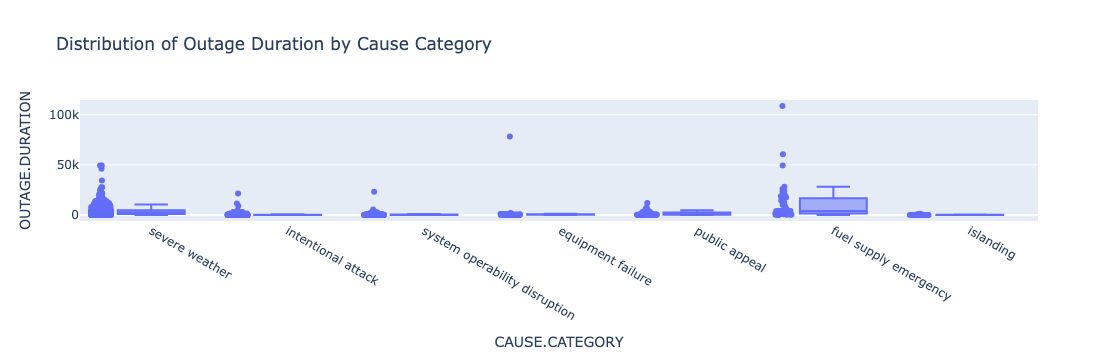

In [25]:
# Plotting

#Boxplot
fig = px.box(outages, x="CAUSE.CATEGORY", y="OUTAGE.DURATION", 
             title="Distribution of Outage Duration by Cause Category",
             points="all")  # Show all points

fig.show()

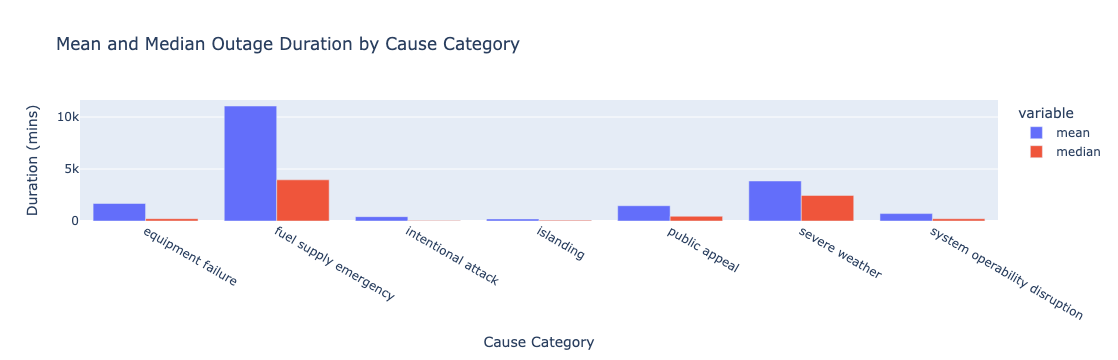

In [24]:
# Bar 
df_summary = outages.groupby("CAUSE.CATEGORY")["OUTAGE.DURATION"].agg(["mean", "median"]).reset_index()

fig = px.bar(df_summary, x="CAUSE.CATEGORY", y=["mean", "median"], 
             title="Mean and Median Outage Duration by Cause Category",
             barmode="group")

fig.update_layout(xaxis_title="Cause Category", yaxis_title="Duration (mins)")
fig.show()

## Step 3: Assessment of Missingness

In [11]:
# TODO

## Step 4: Hypothesis Testing

In [12]:
# TODO

## Step 5: Framing a Prediction Problem

In [13]:
# TODO

## Step 6: Baseline Model

In [14]:
# TODO

## Step 7: Final Model

In [15]:
# TODO

## Step 8: Fairness Analysis

In [16]:
# TODO